# Data Science Bowl 2017 - Improve Lung Cancer Detection

The Data Science Bowl, presented by Booz Allen and Kaggle, is a data science for social good competition.  It's open to data scientists, technologists, domain experts, and organizations to take on the world’s challenges with data and technology.  In this year's competition, the challenge is to use machine learning to quickly detect lung cancer.  I chose to do this competition to tackle an issue that is affecting hundreds of thousands of people per year.  

### Background:

In the United States, lung cancer strikes 225,000 people every year, and accounts for $12 billion in health care costs. Early detection is critical to give patients the best chance at recovery and survival.  According to the [National Institutes of Health(NIH)](https://www.nih.gov/), 20% of lung cancer deaths can be reduced with early detection.  There is also a high number of false positive rates that result from existing image assessments.  This means that there's a high number of lung lesions that are diagnosed as cancerous that later turn out to be benign.  This leads to patient anxiety and the added cost of follow-up imaging and treatments that may not be needed at all.  

### The Data

The dataset contains thousands of low-dose CT images from high risk patients in [DICOM](https://en.wikipedia.org/wiki/DICOM) format.  Each scan contains a series of multiple axial slices of the chest cavity.

The images in the dataset come from many sources and will vary in quality.  For example, older scans were imaged with less sophisticated equipment and have thicker slices.  The algorithm/s used should be able to perform well across a range of image quality.   

I forgot to mention that this is a 2 stage competition.  At the time of writing, the first stage data was available.  Stage 2 should contain higher quality images with thinner slice thickness.  

On the competition's data page, we can access the relevant files for this project. 

**Files**

* **stage1.7z** - contains all images from the first stage of the competition, including both training and test set.  
* **sample_images.7z** - contains sample images
* **stage1_labels.csv** - contains the cancer ground truth for the stage 1 training set images
* **stage1_sample_submission.csv** - shows the submission format for stage 1.
* **data_password.txt** - contains the decryption key for the image files

Working with the scans can be a challenge and some preprocessing is required before training a neural network or other algorithm on the data.  To help with the preprocessing, I used [Guido Zuidhof's Full Preprocessing Tutorial](https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial) as a guide.  Prior to this competition, I've never worked with DICOM files nor did I know how to preprocess them.  Fortunately, this tutorial sheds light on this and was very helpful.

### Explore Data

In [54]:
%matplotlib inline
import numpy as np
import pandas as pd
import pydicom as dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import time
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
 
STAGE1_INPUTS = '../data/raw/image_data/stage1/'
STAGE1_LABELS = '../data/raw/stage1_labels.csv'
STAGE1_SAMPLE_SUBMISSION = '../data/raw/stage1_sample_submission.csv'
SAMPLE_IMAGES = '../data/raw/sample_images/'

# list of folders in directory
patients = os.listdir(STAGE1_INPUTS)
patients.sort()

In [ ]:
import sys

def set_sys_path(directory):
    '''Sets directory as default path'''
    sys.path.insert(0, directory)
    
# Set path to data folder containing raw data
# set_sys_path('../src/data/')

### Explore Training Set Labels

In [55]:
train_labels = pd.read_csv(STAGE1_LABELS)
print('Stage1 Labels file consists of {} rows and {} columns \n'.format(train_labels.shape[0], train_labels.shape[1]))
train_labels.head()

Stage1 Labels file consists of 1397 rows and 2 columns 



,id,cancer
0,0015ceb851d7251b8f399e39779d1e7d,1
1,0030a160d58723ff36d73f41b170ec21,0
2,003f41c78e6acfa92430a057ac0b306e,0
3,006b96310a37b36cccb2ab48d10b49a3,1
4,008464bb8521d09a42985dd8add3d0d2,1


### Explore Sample Submission

In [56]:
sample_submission = pd.read_csv(STAGE1_SAMPLE_SUBMISSION)
print('Sample Submission file consists of {} rows and {} columns \n'.format(sample_submission.shape[0], sample_submission.shape[1]))
sample_submission.head()

Sample Submission file consists of 198 rows and 2 columns 



,id,cancer
0,026470d51482c93efc18b9803159c960,0.5
1,031b7ec4fe96a3b035a8196264a8c8c3,0.5
2,03bd22ed5858039af223c04993e9eb22,0.5
3,06a90409e4fcea3e634748b967993531,0.5
4,07b1defcfae5873ee1f03c90255eb170,0.5


### Image Data

The scans I'll work with are located in the stage1.7z file.   Every folder contains one scan for a unique patient.  Each scan consists of multiple slices.  Here is a sample showing the number of slices for 10 randomly chosen patients.  We can see that the number of slices varies per patient.  I also printed out the total number of patient scans in the stage1 dataset.

In [57]:
def get_slice_count(path, num_scans):
    for d in os.listdir(path)[:num_scans]:
        print("Patient scan '{}' has {} slices".format(d, len(os.listdir(path + d))))
    print('\n Total number of patient scans in folder:', len(os.listdir(path)))

get_slice_count(path = STAGE1_INPUTS, num_scans = 10)

Patient scan '0015ceb851d7251b8f399e39779d1e7d' has 195 slices
Patient scan '0030a160d58723ff36d73f41b170ec21' has 265 slices
Patient scan '003f41c78e6acfa92430a057ac0b306e' has 233 slices
Patient scan '006b96310a37b36cccb2ab48d10b49a3' has 173 slices
Patient scan '008464bb8521d09a42985dd8add3d0d2' has 146 slices
Patient scan '0092c13f9e00a3717fdc940641f00015' has 171 slices
Patient scan '00986bebc45e12038ef0ce3e9962b51a' has 123 slices
Patient scan '00cba091fa4ad62cc3200a657aeb957e' has 134 slices
Patient scan '00edff4f51a893d80dae2d42a7f45ad1' has 135 slices
Patient scan '0121c2845f2b7df060945b072b2515d7' has 191 slices

 Total number of patient scans in folder: 1595


### Sample Images

In [58]:
get_slice_count(path = SAMPLE_IMAGES, num_scans = 5)

Patient scan '00cba091fa4ad62cc3200a657aeb957e' has 134 slices
Patient scan '0a099f2549429d29b32f349e95fb2244' has 128 slices
Patient scan '0a0c32c9e08cc2ea76a71649de56be6d' has 133 slices
Patient scan '0a38e7597ca26f9374f8ea2770ba870d' has 110 slices
Patient scan '0acbebb8d463b4b9ca88cf38431aac69' has 203 slices

 Total number of patient scans in folder: 20


### Scan metadata 

The scans contain metadata, such as pixel spacing and the patient name.  Here I'll preview one dicom file to show you what it contains:

In [59]:
dcm = STAGE1_INPUTS + '0015ceb851d7251b8f399e39779d1e7d/00ac2629fe659e68f4879da4812af659.dcm'

dcm_metadata = dicom.read_file(dcm)
dcm_metadata

(0008, 0000) Group Length                        UL: 358
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.7009.9004.266857665440469517895487635133
(0008, 0060) Modality                            CS: 'CT'
(0008, 103e) Series Description                  LO: 'Axial'
(0010, 0000) Group Length                        UL: 64
(0010, 0010) Patient's Name                      PN: '0015ceb851d7251b8f399e39779d1e7d'
(0010, 0020) Patient ID                          LO: '0015ceb851d7251b8f399e39779d1e7d'
(0010, 0030) Patient's Birth Date                DA: '19000101'
(0018, 0060) KVP                                 DS: ''
(0020, 0000) Group Length                        UL: 388
(0020, 000d) Study Instance UID                  UI: 2.25.51820907428519808061667399603379702974102486079290552633235
(0020, 000e) Series Instance UID           

Notice that the 'KVP' field is missing from this file.  

##  Preprocessing a Sample Scan

Each slice in the dataset has to go through preprocessing before training can begin. Here, I'll preprocess a sample scan to visualize the process.  


### Load DICOM files

The pixel slice thickness for each scan is missing.  The code below loads the slices in each scan into a list and adds the slice thickness to the metadata.  The slice thickness is the difference in thickness between connected slices.  

In [102]:
def load_scan(path):
    '''Loads slices and calculates slice thickness'''
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices

# A list of sample scans
sample_patients = os.listdir(SAMPLE_IMAGES)
# use first patient
path = SAMPLE_IMAGES + sample_patients[0]
# A list of slices for first patient
first_patient = load_scan(path)

### Convert Pixel Values to Hounsefield Units

The scans need to be converted to [Housfield units (HU)](https://en.wikipedia.org/wiki/Hounsfield_scale).  HU is a unit of measurement in CT scans that measures radiodensity.  For some images, pixels that fall outside the scanning bounds get a fixed value of -2000.  I have to replace these values with the value 0, which corresponds to air.  

In [95]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
        image[slice_number] += np.int16(intercept)
    return np.array(image, dtype=np.int16)

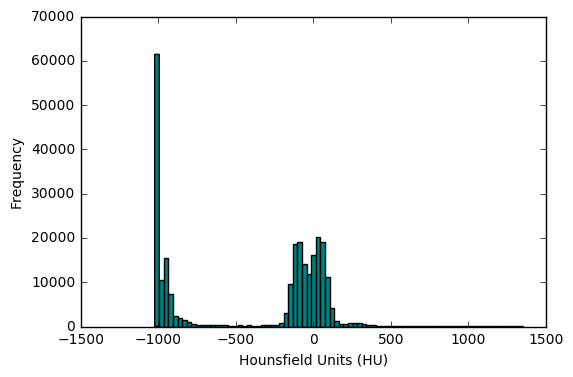

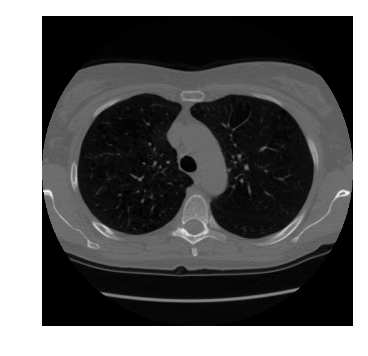

In [103]:
#slices_HU = get_pixels_hu(slices)
slices_HU = get_pixels_hu(first_patient)

plt.hist(slices_HU[0].flatten(), bins=80, color = 'teal')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Preview a slice
plt.axis('off')
plt.imshow(slices_HU[100], cmap = plt.cm.gray)
plt.show()

From the graph, we can see that areas in black represent air while lighter regions could represent tissue. 

### Resampling

I'll need to resample the slices so that they are all the same distance from each other.  

In [93]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [105]:
start = time.time()
pix_resampled, spacing = resample(slices_HU, first_patient, [1,1,1])
end = time.time()
print('Resample complete.  Time elapsed:', end-start)
print("Shape before resampling\t", slices_HU.shape)
print("Shape after resampling\t", pix_resampled.shape)

Resample complete.  Time elapsed: 12.767570495605469
Shape before resampling	 (134, 512, 512)
Shape after resampling	 (335, 306, 306)
